In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("Nat_Gas.csv")
df["Dates"] = pd.to_datetime(df["Dates"])
df.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


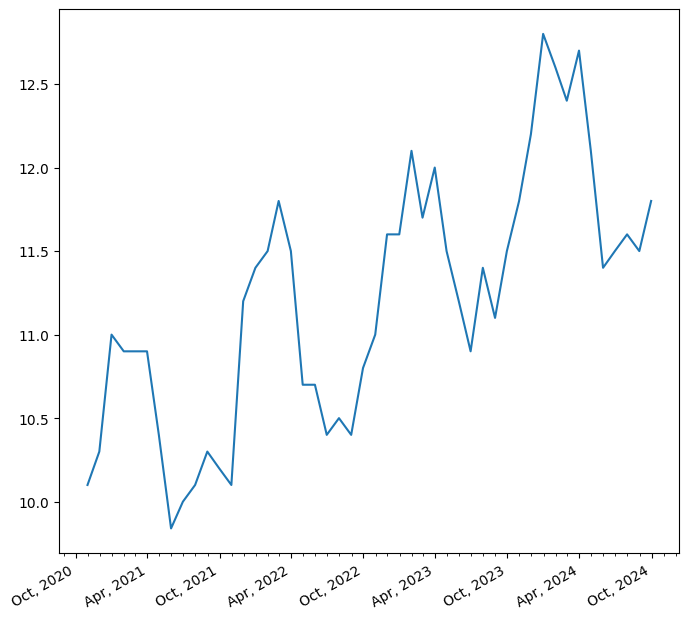

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

monthly_locator = mdates.MonthLocator()
half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%m")
month_year_formatter = mdates.DateFormatter('%b, %Y')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.plot(df["Dates"],df["Prices"])

fig.autofmt_xdate()

In [6]:
year_wise = {} # year : {month : value}
for i in range(len(df)):
    year = df["Dates"][i].date().year
    if year in year_wise:
        year_wise[year][df["Dates"][i].date().month] =  df["Prices"][i]
    else:
        year_wise[year] = {}
        year_wise[year][df["Dates"][i].date().month] =  df["Prices"][i]


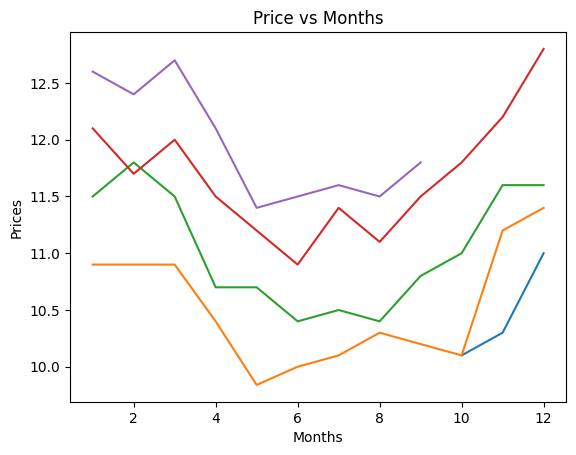

In [7]:
for val in year_wise.values():
  plt.plot(val.keys(),val.values())

plt.xlabel('Months')
plt.ylabel('Prices')
plt.title('Price vs Months')
plt.show()

In [8]:
# prices start increasing from June -> Jan
# prices falls rapidly from March -> June/May hitting lowest for year in Jun/May
# prices roughly remains same between Jan -> March
# Higher Highs and Higer Lows, Bullish run
# Upward Trend + Seasonality

Modeling

Linear regression
In this 12 models are trained on the basis of months, thus only differentiating factor is year, thus lr is of form prices = f(year) given the month.  

In [9]:
# Linear Regression
import datetime as dt
df["Month"] = df["Dates"].dt.month
df.head()

,Dates,Prices,Month
0,2020-10-31,10.1,10
1,2020-11-30,10.3,11
2,2020-12-31,11.0,12
3,2021-01-31,10.9,1
4,2021-02-28,10.9,2


In [14]:
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta

lastdate = df["Dates"].iloc[-1]
predicted_prices = []
model_list = [0]*13

for i in range(1,13):
  date_to_predict = (lastdate + relativedelta(months = 1))
  month =  date_to_predict.date().month
  year =   date_to_predict.date().year

  y = np.array(df[df.Month == month]["Prices"])
  X = np.array(df[df.Month == month]["Dates"].dt.year).reshape(-1,1)

  lr = LinearRegression().fit(X, y)

  pred_prices = lr.predict(np.array([[year]]))
  predicted_prices.extend(pred_prices)

  model_list[month] = lr

  if year not in year_wise:
    year_wise[year] = {}
  year_wise[year][month] =  pred_prices[0]

  lastdate = date_to_predict


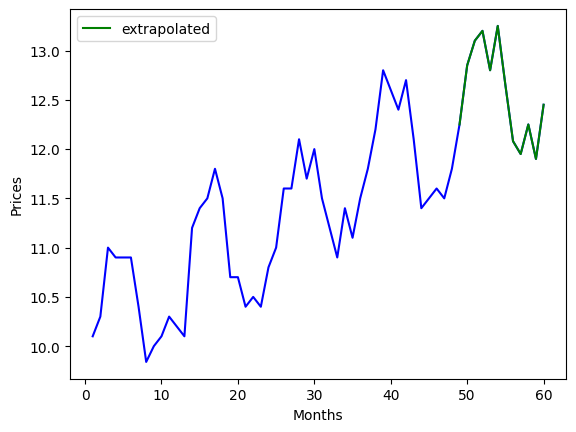

In [15]:
n = len(np.concatenate( (np.array(df["Prices"][:]),np.array(predicted_prices)) ))

plt.plot(np.arange(1,n+1), np.concatenate( (np.array(df["Prices"][:]),np.array(predicted_prices)) ) ,color = "blue")
plt.plot(np.arange(len(np.array(df["Prices"][:]))+1, len(np.array(df["Prices"][:]))+1+len(predicted_prices)), np.array(predicted_prices), color = "green", label = "extrapolated")
plt.xlabel("Months")
plt.ylabel("Prices")
plt.legend()
plt.show()

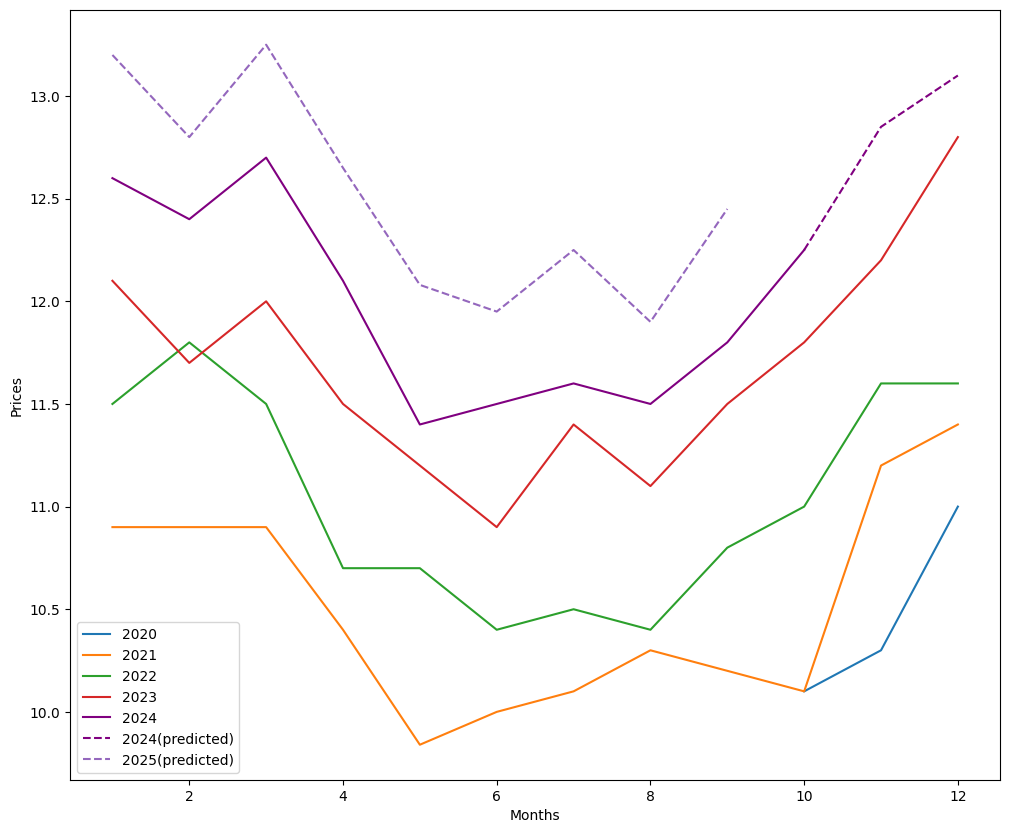

In [12]:
count = 1
year = 2020
plt.figure(figsize=(12,10))
for val in year_wise.values():
  if count == 5:
    plt.plot(list(val.keys())[:10],list(val.values())[:10], color = 'purple',label = year )
    plt.plot(list(val.keys())[-3:],list(val.values())[-3:], color = 'purple', linestyle='dashed', label = str(year) + "(predicted)" )
  elif count == 6:
    plt.plot(val.keys(),val.values(),linestyle='dashed',label = str(year) + "(predicted)")
  else:
    plt.plot(val.keys(),val.values(),label = year )

  year+=1
  count+=1

plt.xlabel("Months")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [19]:
# Prediction

year = int(input("Enter year : "))
month = int(input("Enter month : "))

extract_model = model_list[month]
pred_prices = extract_model.predict(np.array([[year]]))

print("Predict Price : ", pred_prices[0])


Enter year : 2025
Enter month : 5
Predict Price :  12.080000000000155


Time Series Analysis

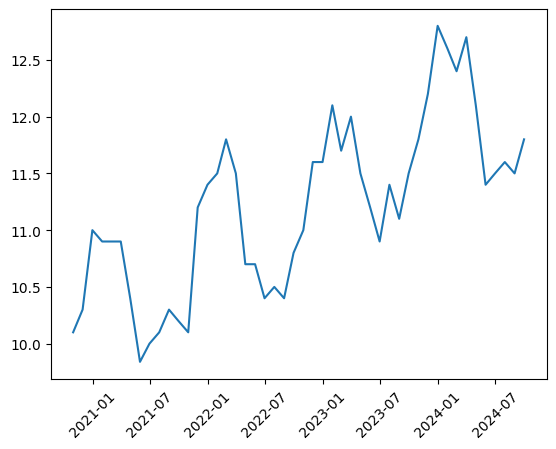

In [20]:
plt.plot(df["Dates"],df["Prices"])
plt.xticks(rotation=45)
plt.show()

In [21]:
df["rollMean"] = df["Prices"].rolling(window=12).mean()
df["rollVar"] = df["Prices"].rolling(window=12).var()

In [22]:
df.head()

,Dates,Prices,Month,rollMean,rollVar
0,2020-10-31,10.1,10,NaN,NaN
1,2020-11-30,10.3,11,NaN,NaN
2,2020-12-31,11.0,12,NaN,NaN
3,2021-01-31,10.9,1,NaN,NaN
4,2021-02-28,10.9,2,NaN,NaN


<Axes: xlabel='Dates', ylabel='Prices'>

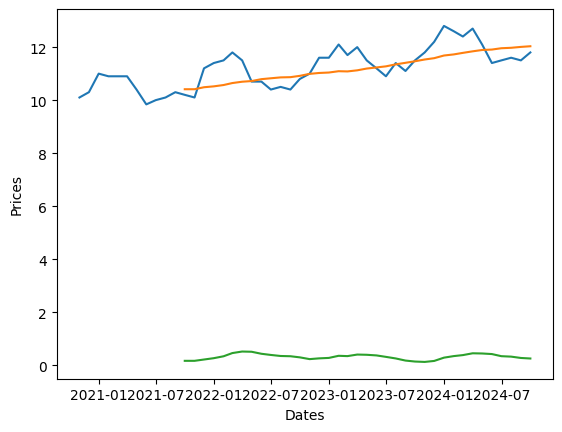

In [23]:
import seaborn as sns
sns.lineplot(data=df,x = df.Dates,y=df.Prices)
sns.lineplot(data=df,x = df.Dates,y=df.rollMean)
sns.lineplot(data=df,x = df.Dates,y=df.rollVar)

In [24]:
# Var is constant, but mean is trending upwards, and data is seasonal => Non-Stationary
from statsmodels.tsa.stattools import adfuller
def checkStationarity(data,col):
  new_col = df[col].dropna()
  adfTest = adfuller(new_col,autolag='AIC',)
  print('ADF Statistic: %f' % adfTest[0])
  print('p-value: %f' % adfTest[1])
  print('Critical Values:')
  for key, value in adfTest[4].items():
    print('\t%s: %.3f' % (key, value))

def plot(ycol,window = 12):
  df["rollMean"] = df[ycol].rolling(window=window).mean()
  df["rollVar"] = df[ycol].rolling(window=window).var()
  sns.lineplot(data=df,x = df.Dates,y=df[ycol])
  sns.lineplot(data=df,x = df.Dates,y=df.rollMean,label = "rolling mean")
  sns.lineplot(data=df,x = df.Dates,y=df.rollVar, label = "rolling var")


In [25]:
checkStationarity(df,"Prices")

ADF Statistic: 0.218077
p-value: 0.973257
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [26]:
# ADF shows data is stationary
# Needs to be converted to Non-Stationary

In [27]:
df["PricesShift_1"] = df["Prices"].shift(1)
df["shift_diff"] = df["Prices"] - df["PricesShift_1"]
df.head()

,Dates,Prices,Month,rollMean,rollVar,PricesShift_1,shift_diff
0,2020-10-31,10.1,10,NaN,NaN,NaN,NaN
1,2020-11-30,10.3,11,NaN,NaN,10.1,0.2
2,2020-12-31,11.0,12,NaN,NaN,10.3,0.7
3,2021-01-31,10.9,1,NaN,NaN,11.0,-0.1
4,2021-02-28,10.9,2,NaN,NaN,10.9,0.0


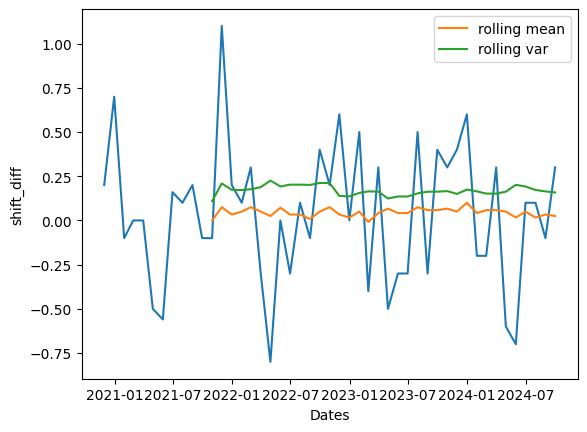

In [28]:
plot("shift_diff",12)
# mean = c, var =c, no seasonality => Can be Stationary

In [29]:
checkStationarity(df,"shift_diff") # var = c, mean = c, no seasonality, p < alpha (0.05) => Stationary

ADF Statistic: -6.844774
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


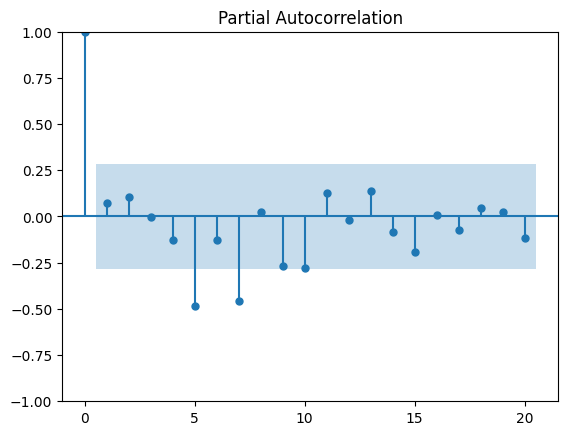

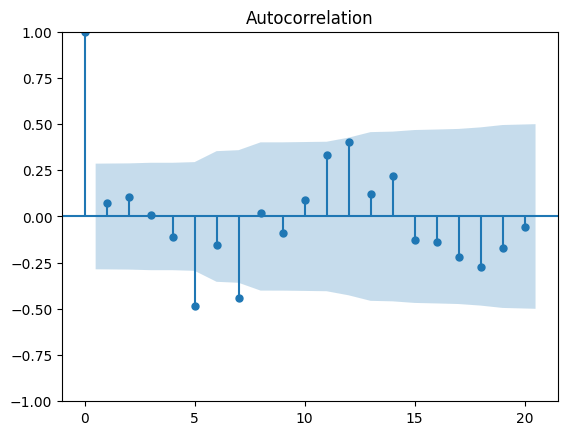

In [31]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df['shift_diff'].dropna(),lags=20);
plot_acf(df['shift_diff'].dropna(),lags=20);

In [ ]:
!pip install pmdarima


In [33]:
import pmdarima as pm

In [34]:
train = df[:int(0.7*(len(df)))]["Prices"]
val = df[int(0.7*(len(df))):]["Prices"]
print(len(train),len(val))

33 15


<Axes: >

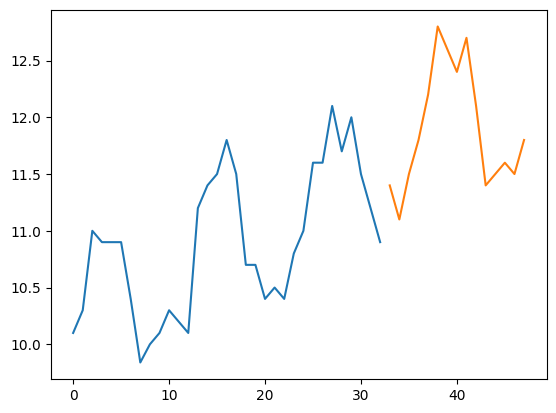

In [36]:
train.plot()
val.plot()

In [37]:
model = pm.auto_arima(df["Prices"],suppress_warnings=True,seasonal=True,
                      stepwise=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=37.147, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.069, Time=4.40 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.330, Time=4.25 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.109, Time=1.79 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.96 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

In [38]:
model.fit(train)

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [40]:
from statsmodels.tools.eval_measures import rmse

forecast = model.predict( len(val) )
forecast = pd.DataFrame(forecast,index = val.index,columns=['Prediction'])
print("RMSE on Val dataset: ", rmse(np.array(val),np.array(forecast['Prediction'])))

RMSE on Val dataset:  0.40891334056037004


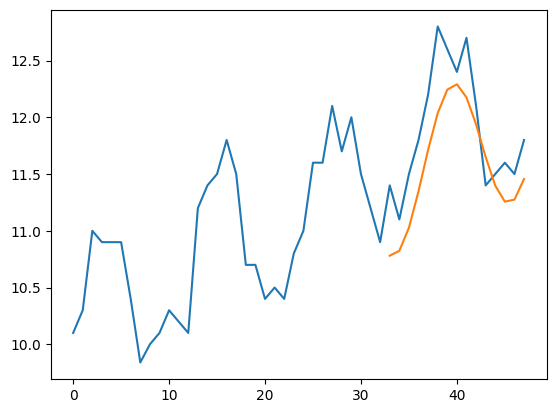

In [41]:
plt.plot(df.Prices, label='Actual')
plt.plot(forecast, label='Prediction')
plt.show()

Manually trying different values

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p,d,q = 2,1,2
P,D,Q = 1,0,1

model = SARIMAX(train, order=(p, q, d), seasonal_order=(P, Q, D, 12))
fitted = model.fit()
predictions = fitted.predict(len(train), len(df)-1)
rmse_val = rmse(np.array(val),np.array(predictions))
print("RMSE on Val dataset: ", rmse(np.array(val),np.array(predictions)))

RMSE on Val dataset:  0.2696068813701919


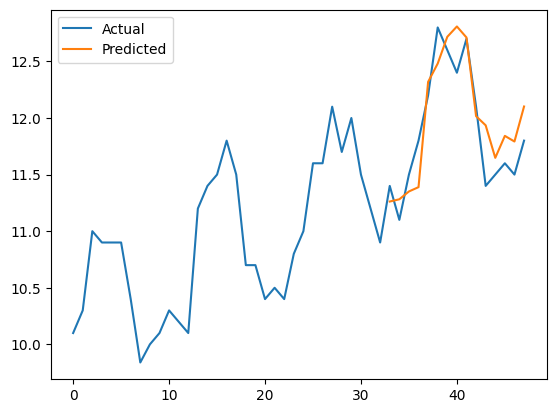

In [46]:
plt.plot(df["Prices"],label="Actual")
plt.plot(predictions,label="Predicted")
plt.legend()

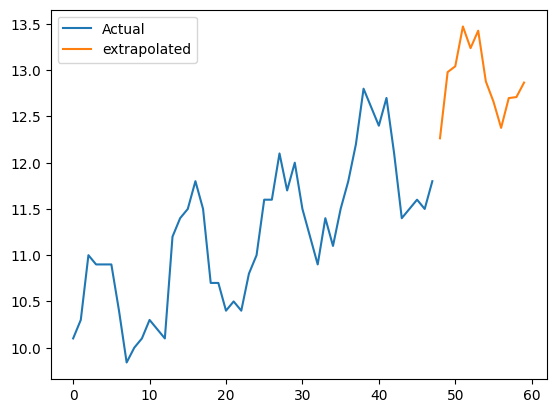

In [45]:
# since this is better than prev model, extrapolating this to one year
predictions_oneyear = fitted.predict(len(df),len(df)+11)
plt.plot(df["Prices"],label="Actual")
plt.plot(predictions_oneyear,label="extrapolated")
plt.legend()

In [86]:
# Making a prediction
import datetime

date = int(input("Enter Date : "))
month = int(input("Enter month : "))
year = int(input("Enter year : "))

user_date = pd.to_datetime(datetime.date(year, month, date))
start_date = df["Dates"][0]

diff_days = user_date - start_date
diff_months = round(diff_days.days/30.44)
# print(diff_months)

prediction = fitted.predict(diff_months)
print("Predict Price : ", prediction[diff_months])

Enter Date : 30
Enter month : 9
Enter year : 2024
Predict Price :  12.101583729607945
